## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [2]:
df = pd.read_csv('data_preprocessed.csv')
df = df.dropna()

In [3]:
df

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0,40,USA,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,13,USA,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0,40,USA,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0,40,USA,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0,40,other,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,245211,Bachelors,Never-married,Prof-specialty,Own-child,White,Male,0.0,0,40,USA,<=50K
48837,39,Private,215419,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0,36,USA,<=50K
48839,38,Private,374983,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0,50,USA,<=50K
48840,44,Private,83891,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0,40,USA,<=50K


In [4]:
X = df.drop('income', axis=1)
y = df['income'].apply(lambda x: 1 if x=='>50K' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [5]:
    
#Author: Klaudia Nazarko
#Source: https://github.com/klaudia-nazarko/iv-and-woe-python

import pandas as pd
import scipy.stats as stats

class CategoricalFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature

    @property
    def df_lite(self):
        df_lite = self.df
        df_lite['bin'] = df_lite[self.feature].fillna('MISSING')
        return df_lite[['bin', 'label']]


class ContinuousFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.bin_min_size = int(len(self.df) * 0.05)

    def __generate_bins(self, bins_num):
        df = self.df[[self.feature, 'label']]
        df['bin'] = pd.qcut(df[self.feature], bins_num, duplicates='drop') \
                    .apply(lambda x: x.left) \
                    .astype(float)
        return df

    def __generate_correct_bins(self, bins_max=20):
        for bins_num in range(bins_max, 1, -1):
            df = self.__generate_bins(bins_num)
            df_grouped = pd.DataFrame(df.groupby('bin') \
                                      .agg({self.feature: 'count',
                                            'label': 'sum'})) \
                                      .reset_index()
            r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['label'])

            if (
                    abs(r)==1 and                                                        # check if woe for bins are monotonic
                    df_grouped[self.feature].min() > self.bin_min_size                   # check if bin size is greater than 5%
                    and not (df_grouped[self.feature] == df_grouped['label']).any()      # check if number of good and bad is not equal to 0
            ):
                break

        return df

    @property
    def df_lite(self):
        df_lite = self.__generate_correct_bins()
        df_lite['bin'].fillna('MISSING', inplace=True)
        return df_lite[['bin', 'label']]
    

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('mode.chained_assignment', None)

class AttributeRelevance():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def bulk_iv(self, feats, iv, woe_extremes=False):
        iv_dict = {}
        for f in feats:
            iv_df, iv_value = iv.calculate_iv(f)
            if woe_extremes:
                iv_dict[f.feature] = [iv_value, iv_df['woe'].min(), iv_df['woe'].max()]
                cols = ['iv', 'woe_min', 'woe_max']
            else:
                iv_dict[f.feature] = iv_value
                cols = ['iv']
        df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=cols)
        return df

    def bulk_stats(self, feats, s):
        stats_dict = {}
        for f in feats:
            p_value, effect_size = s.calculate_chi(f)
            stats_dict[f.feature] = [p_value, effect_size]
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['p-value', 'effect_size'])
        return df

    def analyze(self, feats, iv, s=None, interpretation=False):
        df_iv = self.bulk_iv(feats, iv).sort_values(by='iv', ascending=False)
        if s is not None:
            df_stats = self.bulk_stats(feats, s)
            df_iv = df_iv.merge(df_stats, left_index=True, right_index=True)
        if interpretation:
            df_iv['iv_interpretation'] = df_iv['iv'].apply(iv.interpretation)
            if s is not None:
                df_iv['es_interpretation'] = df_iv['effect_size'].apply(s.interpretation)
        return df_iv

    def draw_iv(self, feats, iv):
        df = self.analyze(feats, iv)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='iv', data=df, palette=self.seq_palette(len(feats)))
        ax.set_title('IV values')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_extremes(self, feats, iv):
        df = self.bulk_iv(feats, iv, woe_extremes=True).sort_values(by='iv', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='woe_min', data=df, palette=self.seq_palette(len(feats)))
        sns.barplot(x=df.index, y='woe_max', data=df, palette=self.seq_palette(len(feats)))
        ax.axhline(y=0, color='black', linewidth=1)
        ax.set_title('Range of WOE values')
        ax.set_ylabel('WOE')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_multiplot(self, feats, iv):
        n = len(feats)
        nrows = int(np.ceil(n/3))
        fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*4))
        for i in range(n):
            iv_df, iv_value = iv.calculate_iv(feats[i])
            sns.barplot(x=feats[i].feature, y='woe', data=iv_df, color='#455872', ax=fig.axes[i])

        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=50)

        plt.tight_layout()
        plt.show()

class Analysis():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def group_by_feature(self, feat):
        df = feat.df_lite \
                            .groupby('bin') \
                            .agg({'label': ['count', 'sum']}) \
                            .reset_index()
        df.columns = [feat.feature, 'count', 'good']
        df['bad'] = df['count'] - df['good']
        return df

class StatsSignificance(Analysis):
    def calculate_chi(self, feat):
        df = self.group_by_feature(feat)
        df_chi = np.array(df[['good', 'bad']])
        n = df['count'].sum()

        chi = stats.chi2_contingency(df_chi)
        cramers_v = np.sqrt(chi[0] / n)          # assume that k=2 (good, bad)
        return chi[1], cramers_v

    @staticmethod
    def interpretation(cramers_v):
        if cramers_v < 0.1:
            return 'useless'
        elif cramers_v < 0.2:
            return 'weak'
        elif cramers_v < 0.4:
            return 'medium'
        elif cramers_v < 0.6:
            return 'strong'
        else:
            return 'very strong'

    def interpret_chi(self, feat):
        _, cramers_v = self.calculate_chi(feat)
        return self.interpretation(cramers_v)

    def print_chi(self, feat):
        p_value, cramers_v = self.calculate_chi(feat)
        print('P-value: %0.2f\nEffect size: %0.2f' % (p_value, cramers_v))
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(cramers_v)))


class IV(Analysis):
    @staticmethod
    def __perc_share(df, group_name):
        return df[group_name] / df[group_name].sum()

    def __calculate_perc_share(self, feat):
        df = self.group_by_feature(feat)
        df['perc_good'] = self.__perc_share(df, 'good')
        df['perc_bad'] = self.__perc_share(df, 'bad')
        df['perc_diff'] = df['perc_good'] - df['perc_bad']
        return df

    def __calculate_woe(self, feat):
        df = self.__calculate_perc_share(feat)
        df['woe'] = np.log(df['perc_good']/df['perc_bad'])
        df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

    def calculate_iv(self, feat):
        df = self.__calculate_woe(feat)
        df['iv'] = df['perc_diff'] * df['woe']
        return df, df['iv'].sum()

    def draw_woe(self, feat):
        iv_df, iv_value = self.calculate_iv(feat)
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=feat.feature, y='woe', data=iv_df, palette=self.seq_palette(len(iv_df.index)))
        ax.set_title('WOE visualization for: ' + feat.feature)
        plt.show()
        plt.show()

    @staticmethod
    def interpretation(iv):
        if iv < 0.02:
            return 'useless'
        elif iv < 0.1:
            return 'weak'
        elif iv < 0.3:
            return 'medium'
        elif iv < 0.5:
            return 'strong'
        else:
            return 'suspicious'

    def interpret_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        return self.interpretation(iv)

    def print_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        print('Information value: %0.2f' % iv)
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(iv)))

In [6]:
df_code = X_train
df_code['label'] = y_train

In [7]:

feat_workclass = CategoricalFeature(df_code, 'workclass')
feat_education = CategoricalFeature(df_code, 'education')
feat_marital = CategoricalFeature(df_code, 'marital-status')
feat_occupation = CategoricalFeature(df_code, 'occupation')
feat_relationship = CategoricalFeature(df_code, 'relationship')
feat_race = CategoricalFeature(df_code, 'race')
feat_sex = CategoricalFeature(df_code, 'sex')
feat_native = CategoricalFeature(df_code, 'native-country')

feat_age = ContinuousFeature(df_code, 'age')
feat_fnlwgt = ContinuousFeature(df_code, 'fnlwgt')
feat_gain = ContinuousFeature(df_code, 'capital-gain')
feat_loss = ContinuousFeature(df_code, 'capital-loss')
feat_hours = ContinuousFeature(df_code, 'hours-per-week')

In [8]:
feats = [feat_workclass,feat_education, feat_marital, feat_occupation, feat_relationship, feat_race, feat_sex, feat_native, feat_age, feat_fnlwgt, feat_gain, feat_gain, feat_loss, feat_hours]

In [9]:
iv = IV()
iv.group_by_feature(feat_race)

,race,count,good,bad
0,Amer-Indian-Eskimo,331,45,286
1,Asian-Pac-Islander,1167,326,841
2,Black,3482,438,3044
3,Other,287,37,250
4,White,31559,8292,23267


In [10]:
iv_df, iv_value = iv.calculate_iv(feat_race)
display(iv_df)
print('Information value: ', iv_value)

,race,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,Amer-Indian-Eskimo,331,45,286,0.004924,0.010329,-0.005405,-0.740772,0.004004
1,Asian-Pac-Islander,1167,326,841,0.035675,0.030374,0.005301,0.160863,0.000853
2,Black,3482,438,3044,0.047932,0.109939,-0.062008,-0.830151,0.051476
3,Other,287,37,250,0.004049,0.009029,-0.004980,-0.801985,0.003994
4,White,31559,8292,23267,0.907420,0.840328,0.067092,0.076813,0.005153


Information value:  0.06547973132796792


<ipython-input-5-82bc77ce26ef>:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat.feature, y='woe', data=iv_df, palette=self.seq_palette(len(iv_df.index)))


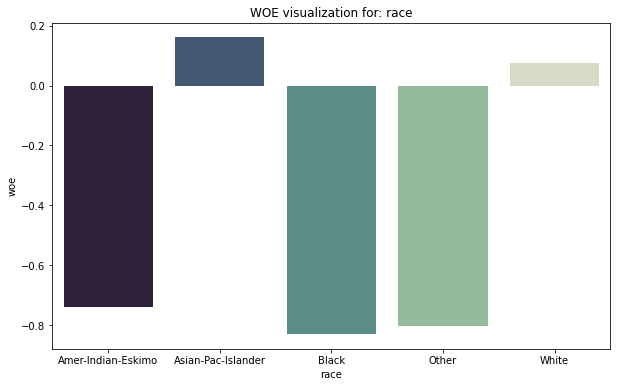

In [11]:

iv.draw_woe(feat_race)

In [12]:
ar = AttributeRelevance()
ar.bulk_iv(feats, iv)

,iv
workclass,0.122965
education,0.727840
marital-status,1.303745
occupation,0.743216
relationship,1.489429
race,0.065480
sex,0.295020
native-country,0.007762
age,0.551244
fnlwgt,0.000155


In [13]:
X_train['capital-loss']

34361    0
29278    0
42494    0
33415    0
46650    0
        ..
1123     0
46370    0
27805    0
34522    0
11104    0
Name: capital-loss, Length: 36826, dtype: int64

In [14]:
ar = ar.bulk_iv(feats, iv)

In [15]:
ar.index

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'age', 'fnlwgt',
       'capital-gain', 'capital-loss', 'hours-per-week'],
      dtype='object')

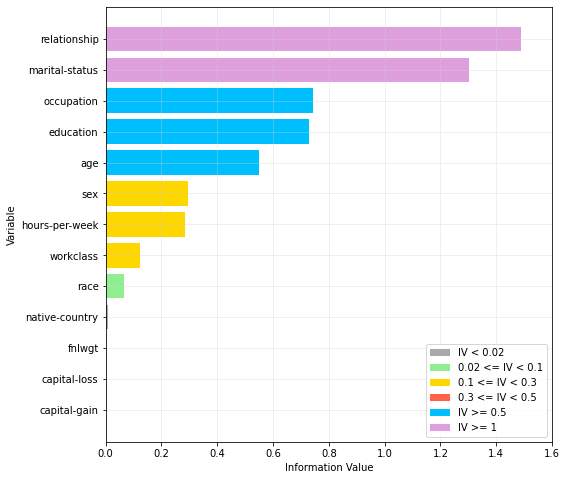

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.pyplot as plt


# Posortuj wartości IV od najdłuższego
iv_sorted_descending = ar.sort_values(by='iv', ascending=True)
# plt.rcParams.update({'font.size': 16})
# Ustal kolor dla słupków na podstawie wartości IV
colors = []
labels = [] 
for iv in iv_sorted_descending['iv']:
    if iv < 0.02:
        colors.append('darkgrey')
    elif 0.02 <= iv < 0.1:
        colors.append('lightgreen')
    elif 0.1 <= iv < 0.3:
        colors.append('gold')
    elif 0.3<=iv<0.5:
        colors.append('tomato')
    elif 0.5<=iv<1:
        colors.append('deepskyblue')
    else:
        colors.append('plum')

# Utwórz wykres słupkowy poziomy dla wartości IV z odpowiednimi kolorami
plt.figure(figsize=(8, 8))
bars = plt.barh(iv_sorted_descending.index, iv_sorted_descending['iv'], color=colors)
plt.xlabel('Information Value')
plt.ylabel('Variable')
plt.xlim(0,1.6)



legend_labels = {
    'darkgrey': 'IV < 0.02',
    'lightgreen': '0.02 <= IV < 0.1',
    'gold': '0.1 <= IV < 0.3',
    'tomato': '0.3 <= IV < 0.5',
    'deepskyblue': 'IV >= 0.5',
    'plum': 'IV >= 1'
}

# Dodajemy legendę ręcznie dla każdego koloru
for color, label in legend_labels.items():
    plt.bar(0, 0, color=color, label=label)

# Dodajemy legendę główną (prawdziwą) w celu ukrycia "pustych" słupków w prawym górnym rogu
plt.legend(loc='lower right')
plt.grid(True, color='lightgrey',alpha=0.4)
# plt.savefig('plots/IV.pdf', bbox_inches='tight')
plt.show()

In [17]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()

In [30]:
df_analysis = ar.analyze(feats, iv, s, interpretation=True)
display(df_analysis)['iv',	'p-value']

,iv,p-value,effect_size,iv_interpretation,es_interpretation
relationship,1.489429,0.000000e+00,0.453668,suspicious,strong
marital-status,1.303745,0.000000e+00,0.446719,suspicious,strong
occupation,0.743216,0.000000e+00,0.344171,suspicious,medium
education,0.727840,0.000000e+00,0.364837,suspicious,medium
age,0.551244,0.000000e+00,0.284313,suspicious,medium
sex,0.295020,0.000000e+00,0.215316,medium,medium
hours-per-week,0.283743,0.000000e+00,0.237334,medium,medium
workclass,0.122965,2.736928e-209,0.163454,medium,weak
race,0.065480,6.929209e-78,0.099660,weak,useless
native-country,0.007762,1.726507e-12,0.036764,useless,useless


TypeError: 'NoneType' object is not subscriptable

In [19]:
import numpy as np
from scipy.stats import f_oneway

In [24]:
df[df['income'] == ">50K"]['age']

7        52
8        31
9        42
10       37
11       30
         ..
48815    38
48816    43
48822    40
48826    50
48841    35
Name: age, Length: 11422, dtype: int64

In [25]:
f_oneway(df[df['income'] == ">50K"]['age'], df[df['income'] != ">50K"]['age'])

F_onewayResult(statistic=2747.6599617746087, pvalue=0.0)

In [26]:
f_oneway(df[df['income'] == ">50K"]['fnlwgt'], df[df['income'] != ">50K"]['fnlwgt']) # tylko tutaj nie ma różnicy w rozkładach

F_onewayResult(statistic=2.167874327331898, pvalue=0.14092774334337155)

In [27]:
f_oneway(df[df['income'] == ">50K"]['capital-gain'], df[df['income'] != ">50K"]['capital-gain'])

F_onewayResult(statistic=4912.308949450461, pvalue=0.0)

In [28]:
f_oneway(df[df['income'] == ">50K"]['capital-loss'], df[df['income'] != ">50K"]['capital-loss'])

F_onewayResult(statistic=1050.9592085683105, pvalue=5.610247901991136e-228)

In [29]:
f_oneway(df[df['income'] == ">50K"]['hours-per-week'], df[df['income'] != ">50K"]['hours-per-week'])

F_onewayResult(statistic=2496.0413297053888, pvalue=0.0)